  # Machine Learning and Predictive Modeling - Assignment 7
  ### Arpit Parihar
  ### 05/17/2021
  ****

  **Importing modules**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pretty_cm import pretty_plot_confusion_matrix

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import load_model

import os
import glob

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

 ### 1\. Data Processing

In [2]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
X_train = train_datagen.flow_from_directory(
    './dataset_train/',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 88 images belonging to 4 classes.


 **Plotting training images**

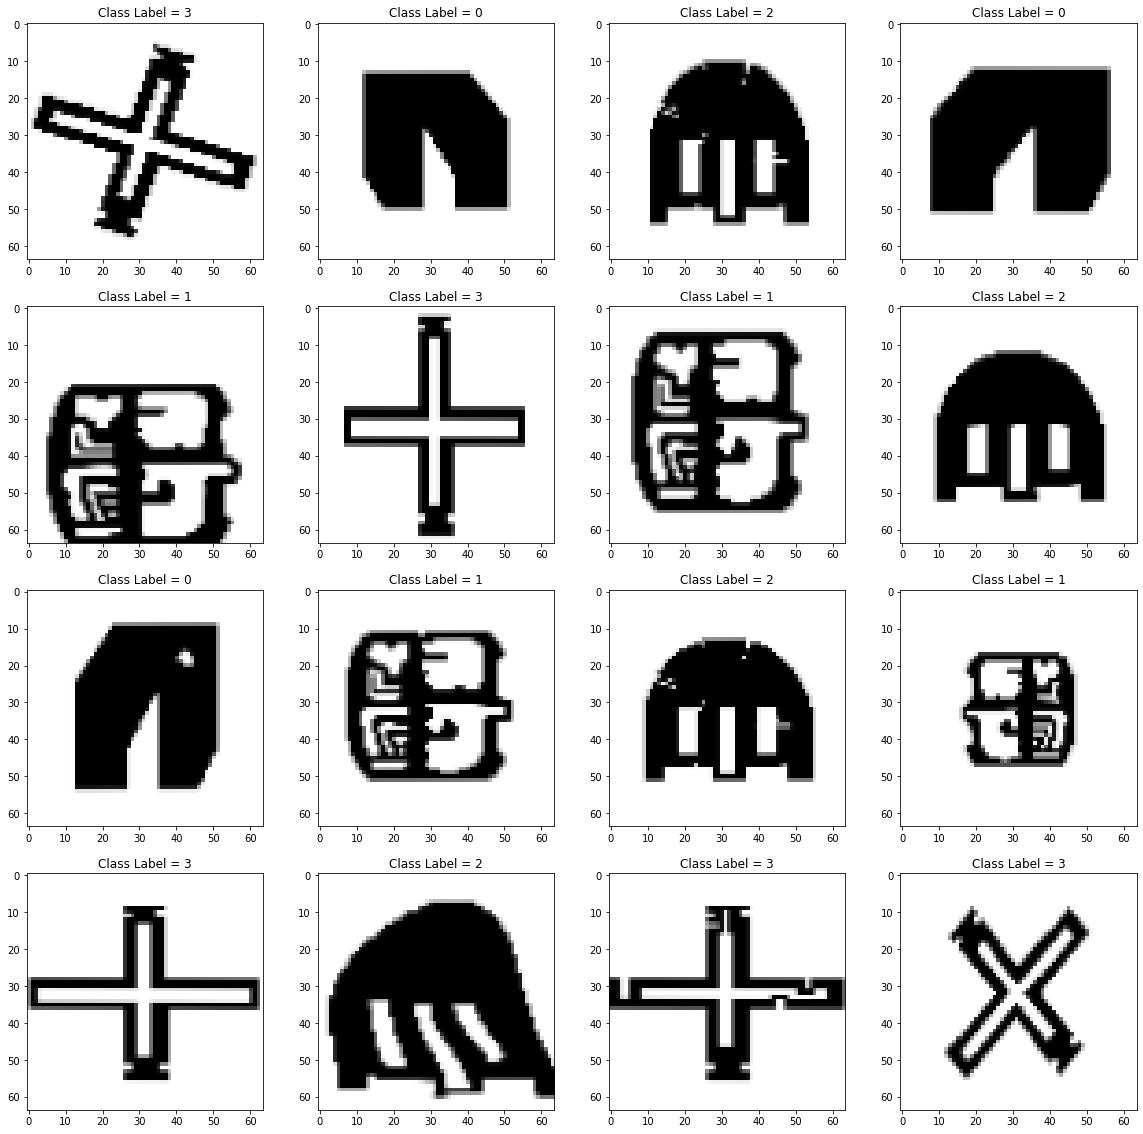

In [3]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20));

for i, ax in enumerate(axs.flatten()):
    img, label = X_train.next()
    _ = ax.set_title(f'Class Label = {np.argmax(label[i])}');
    _ = ax.imshow(img[i]);

 **Shape of training images**

In [4]:
img_shape = X_train.next()[0][0].shape
img_shape

(64, 64, 3)

 ### 2\. Initial Classifier Build

In [5]:


def build_and_compile():
    classifier = Sequential()
    classifier.add(
        Conv2D(
            32, kernel_size=(3, 3),
            activation='relu',
            input_shape=img_shape))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(128, activation='relu'))
    classifier.add(Dense(4, activation='softmax'))

    classifier.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy'])
    return classifier



 ### 3\. Model Runs:

In [6]:
try:
    classifier = load_model('./Models/baseline_model.h5')
    print('Baseline model loaded from disk')
except:
    classifier = build_and_compile()
    steps_per_epoch = 3
    epochs = 3
    classifier.fit(
        X_train,
        steps_per_epoch=X_train.samples // 32 +
        min(X_train.samples % 32, 1),
        epochs=epochs)
    classifier.save('./Models/baseline_model.h5')
    print('Baseline model saved')

Baseline model loaded from disk


 **Making predictions**

 Reading test data and creating labels

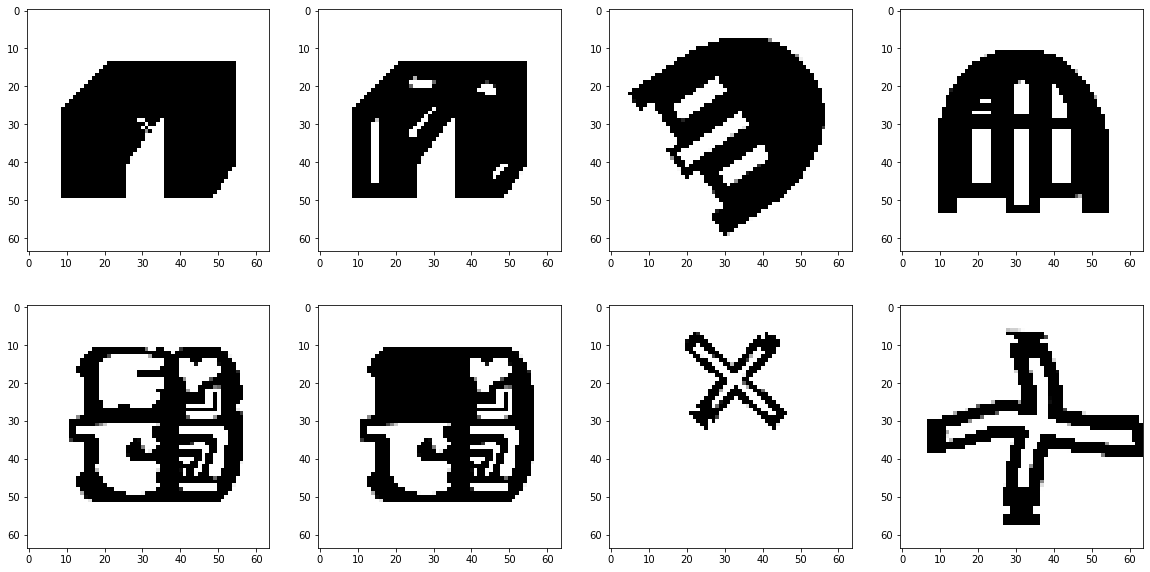

In [7]:
files = glob.glob(os.path.join('./dataset_test/', '*.png'))

X_test = []
fig, axs = plt.subplots(2, 4, figsize=(20, 10));

for (i, file) in enumerate(files):
    img = image.load_img(file, target_size = (64, 64))
    img = image.img_to_array(img);
    _ = axs.flatten()[i].imshow(img.astype(np.uint8))
    img = np.expand_dims(img, axis = 0)
    X_test.append(img)

y_test = [0, 0, 1, 1, 2, 2, 3, 3]


 Creating functions for predictions and classification report

In [8]:

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def classification_results(act, pred, labels, header=None):
    print(color.UNDERLINE + color.BOLD + header + ':\n' + color.END)
    print('Confusion Matrix:\n')
    plt.pause(1)
    pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(
        act, pred), columns=labels, index=labels), pred_val_axis='x')
    plt.show()
    print('\n' + '-' * 75 + '\n')
    print(classification_report(act, pred, digits=4))
    print('\n' + '-' * 75 + '\n')

def predict_test(model):
    y_pred = []
    for i in X_test:
        y_pred.append(np.argmax(model.predict(i)))
    return y_pred, accuracy_score(y_test, y_pred)

 Printing classification report

Baseline:

Confusion Matrix:



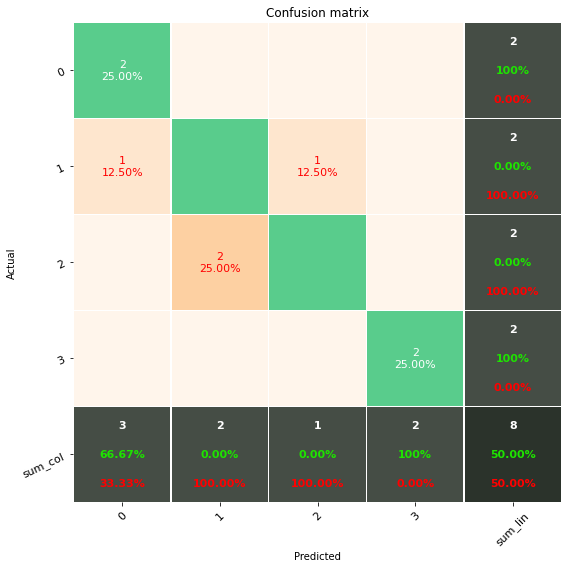


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.6667    1.0000    0.8000         2
           1     0.0000    0.0000    0.0000         2
           2     0.0000    0.0000    0.0000         2
           3     1.0000    1.0000    1.0000         2

    accuracy                         0.5000         8
   macro avg     0.4167    0.5000    0.4500         8
weighted avg     0.4167    0.5000    0.4500         8


---------------------------------------------------------------------------



In [9]:
classification_results(y_test, predict_test(classifier)[0], range(4), 'Baseline')

In [10]:
models = {}

for (i, j) in zip([1] * 3 + [2] * 3 + [3] * 2 + [5] * 2, range(1, 11)):
    try:
        models[f'{i}_{j}'] = load_model(f'./Models/model_{i}_{j}.h5')
        print(f'Model_{i}_{j} loaded from disk')
    except:
        classifier = build_and_compile()
        classifier.fit(
            train_datagen.flow_from_directory(
                './dataset_train/',
                target_size=(64, 64),
                batch_size=X_train.samples // i +
                min(X_train.samples % i, 1),
                class_mode='categorical'),
            epochs=j,
            verbose=0)
        models[f'{i}_{j}'] = classifier
        classifier.save(f'./Models/model_{i}_{j}.h5')
        print(f'Model_{i}_{j} saved to disk')

Model_1_1 loaded from disk
Model_1_2 loaded from disk
Model_1_3 loaded from disk
Model_2_4 loaded from disk
Model_2_5 loaded from disk
Model_2_6 loaded from disk
Model_3_7 loaded from disk
Model_3_8 loaded from disk
Model_5_9 loaded from disk
Model_5_10 loaded from disk


In [11]:
pd.DataFrame({
    'steps':[eval(x.replace('_', ','))[0] for x in models],
    'epochs':[eval(x.replace('_', ','))[1] for x in models],
    'accuracy':[predict_test(models[x])[1] for x in models]
})


,steps,epochs,accuracy
0,1,1,0.250
1,1,2,0.250
2,1,3,0.250
3,2,4,0.625
4,2,5,0.500
5,2,6,0.500
6,3,7,0.625
7,3,8,0.250
8,5,9,0.500
9,5,10,0.375
